In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss, accuracy_score
from sklearn.decomposition import PCA
import category_encoders as ce

pd.options.display.max_columns = 999


In [5]:
df = pd.read_csv('train.csv')
df.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


# Feature engineering - Walmart dataset

* Ordinal encoding na zmiennej weekday - zachowanie struktury tygodnia
* One hot encoding na department description - zamiast jedynek wstawiamy ScanCount
* Grupujemy wiersze po visitNumber i sumujemy scanCount dla poszczególnych department description

In [6]:
pivoted = df.pivot_table(index="VisitNumber", columns='DepartmentDescription', values='ScanCount', fill_value=0)
pivoted=pivoted.rename(columns=str).reset_index()
no_duplicates_df = df.loc[:,['TripType','VisitNumber','Weekday']].drop_duplicates()
no_duplicates_df.reset_index(drop=True, inplace=True)
data = pivoted.merge(no_duplicates_df, on='VisitNumber').drop('VisitNumber', axis=1)
data = data.loc[data.TripType!=14,:]

ordinal_cols_mapping = [
    {"col":"Weekday",
    "mapping":[
        ("Monday",0),
        ("Tuesday",1),
        ("Wednesday",2),
        ("Thursday",3),
        ("Friday",4),
        ("Saturday",5),
        ("Sunday",6)
    ]}
]

data = ce.OrdinalEncoder(mapping=ordinal_cols_mapping).fit_transform(data)

X, y = data.drop('TripType', axis=1), data.loc[:,'TripType'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Przy tak wykonanej inżynierii cech, możemy już wizualnie wyróżnić poszczególne rodzaje wizyt

poniżej możemy zobaczyć wykresy średniej liczby scan count dla poszczególnych Department Description

In [ ]:
plt.figure(figsize=(16,9))
data.drop('Weekday',axis=1).groupby('TripType').mean().loc[4].plot(kind='bar')
plt.title('TripType 4\n', size=40)
plt.show()

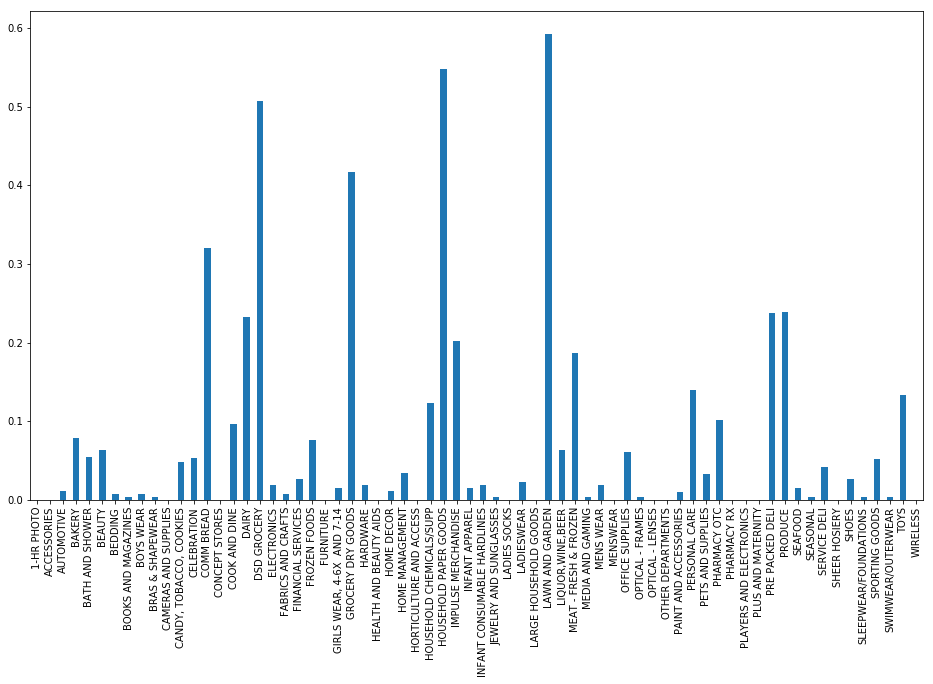

In [9]:
plt.figure(figsize=(16,9))
data.drop('Weekday',axis=1).groupby('TripType').mean().loc[12].plot(kind='bar')
plt.title('TripType 4\n', size=40)
plt.show()

In [10]:
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

/home/kacper/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [11]:
print(f'training set log loss: {log_loss(y_train, classifier.predict_proba(X_train))}')
print(f'cross validation set log loss: {-np.mean(cross_val_score(classifier, X_train, y=y_train, cv=5,scoring="neg_log_loss"))}')

training set log loss: 0.43662721643058483
cross validation set log loss: 5.6385744902644275


In [12]:
y_pred_proba = classifier.predict_proba(X_test)
log_loss(y_test, y_pred_proba)

5.562952410038641

# High Variance - Model is overfitted = too complex

In [ ]:
classifier = RandomForestClassifier(n_estimators=800, max_depth=12, n_jobs=5)
classifier.fit(X_train, y_train)

print(f'training set log loss: {log_loss(y_train, classifier.predict_proba(X_train))}')
print(f'cross validation set log loss: {-np.mean(cross_val_score(classifier, X_train, y=y_train, cv=5,scoring="neg_log_loss"))}')

training set log loss: 1.7516834210174848


# Wpływ zmiennych na podstawie częstości występowania w modelu

In [ ]:
feat_importances = pd.Series(classifier.feature_importances_, index=X.columns)
plt.figure(figsize=(16,16))
feat_importances.sort_values(ascending=True).plot(kind='barh', color='lightgreen')
plt.show()

# Końcowa postać ramki danych

In [ ]:
X_train.head()